# Pick out cues from Accelerometer data

Alternative alignment extraction path for multidevice accelerometry recordings. 

Some recordings include only one tapping or clapping cue, some include multiple.

For a single accelerometry recording:

    0. Load accelerometry file, resample and collapse to 1D absolut Jerk. 
    1. Load all relevant template cues and their approximate position.
    2. Automate IDing each synchronisation cue in the  with cross correlations.
    3. Review cue timing
    4. Save the detected timing of each cue IN DEVICE TIMESTAMP VALUES
    
Output timing information is used in a difference script to shift recordings to common concert time.

## libraries and function files

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json 
from scipy.signal import butter, filtfilt, argrelextrema
from scipy import interpolate
from scipy.interpolate import interp1d

In [2]:
%load_ext autoreload
%autoreload 1
%aimport eq
%aimport qex
%aimport al

In [142]:
%reload_ext autoreload

# Cue Templates
Pull in the one or many cue templates used to locate cue timing in the jerk data

This sequence constructs the cue from a sequence of peak timings (claps or taps)

In [111]:
synch_times = {'C1_Synch':pd.to_datetime('2023-02-16 8:33:18.324+0000'),
               'C1_Reic':pd.to_datetime('2023-02-16 08:45:22.246+0000'),#'RE':pd.to_datetime('2023-02-15 11:25:26.573+0100'),
               'C2_Synch':pd.to_datetime('2023-02-16 10:16:22.697+0000'),
               'C2_Reic':pd.to_datetime('2023-02-16 10:27:10.927+0000')}
c_types = {'C1_Reic':'claps',#'RE':pd.to_datetime('2023-02-15 11:25:26.573+0100'),
                 'C2_Reic':'claps', # 97.0 
                 'C1_Synch':'taps',
                 'C2_Synch':'taps'}

In [11]:
CueT={} # list of cues to check
# sample rate for comparison between cue template and signal
sf = 100
t_range= [-10,20]

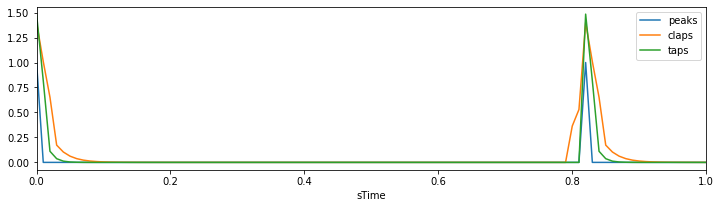

In [12]:
# tap source
cue_times = pd.read_csv('./Timing/short_synch_cue.csv',",",header=None) #SV alignment for beeps
cue_times['S_AudioTime'] = np.round(cue_times[0],3) # reset to 50 hz
cue_times['event'] = cue_times[1]
cue_times['CTime'] = cue_times['S_AudioTime']-cue_times.loc[3,'S_AudioTime'] # zero on onset of first synch cue
peak_times = cue_times.loc[cue_times['event'].str.startswith('Tap'),'CTime']
cue = al.cue_template_make(peak_times,sf,t_range)

cue.plot(x='sTime',y=['peaks','claps','taps'],figsize=[12,3])
plt.xlim([0,1])

CueT['C1_Synch'] = cue

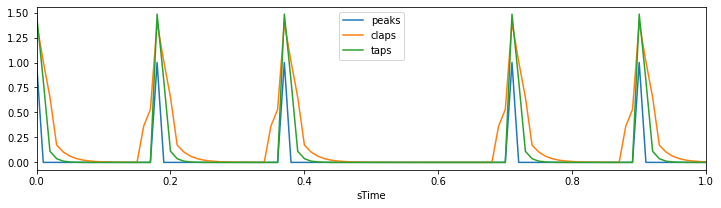

In [13]:
# riechs source
cue_times = pd.read_csv('./Timing/C1_reic_claps.csv',",") 
peak_times = list(cue_times['TIME']-cue_times.loc[0,'TIME'])
cue = al.cue_template_make(peak_times,sf,t_range)

cue.plot(x='sTime',y=['peaks','claps','taps'],figsize=[12,3])
plt.xlim([0,1])

CueT['C1_Reic'] = cue

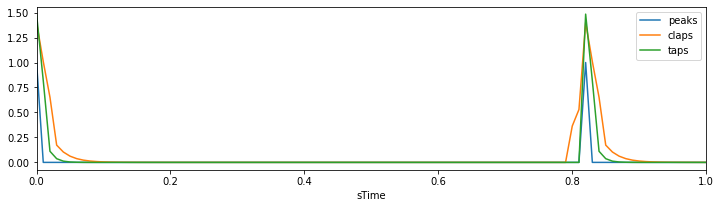

In [14]:
# tap source

cue_times = pd.read_csv('./Timing/short_synch_cue.csv',",",header=None) #SV alignment for beeps
cue_times['S_AudioTime'] = np.round(cue_times[0],3) # reset to 50 hz
cue_times['event'] = cue_times[1]
cue_times['CTime'] = cue_times['S_AudioTime']-cue_times.loc[3,'S_AudioTime'] # zero on onset of first synch cue
peak_times = cue_times.loc[cue_times['event'].str.startswith('Tap'),'CTime']

cue = al.cue_template_make(peak_times,sf,t_range)
cue.plot(x='sTime',y=['peaks','claps','taps'],figsize=[12,3])
plt.xlim([0,1])
CueT['C2_Synch'] = cue

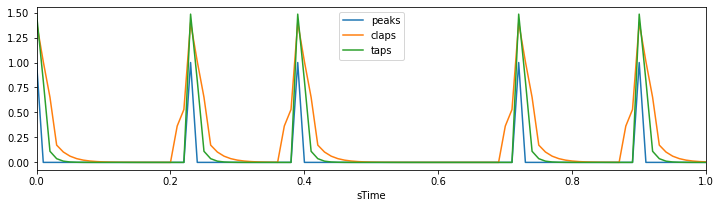

In [15]:
# riechs source
cue_times = pd.read_csv('./Timing/C2_reic_claps.csv',",") 
peak_times = list(cue_times['TIME']-cue_times.loc[0,'TIME'])

cue = al.cue_template_make(peak_times,sf,t_range)
cue.plot(x='sTime',y=['peaks','claps','taps'],figsize=[12,3])
plt.xlim([0,1])
CueT['C2_Reic'] = cue

In [16]:
# Interval of time taken from signal to search for cue
cue

,sTime,peaks,taps,claps
0,-10.00,0,0.0,0.0
1,-9.99,0,0.0,0.0
2,-9.98,0,0.0,0.0
3,-9.97,0,0.0,0.0
4,-9.96,0,0.0,0.0
...,...,...,...,...
2995,19.95,0,0.0,0.0
2996,19.96,0,0.0,0.0
2997,19.97,0,0.0,0.0
2998,19.98,0,0.0,0.0


In [17]:
CueT.keys()

dict_keys(['C1_Synch', 'C1_Reic', 'C2_Synch', 'C2_Reic'])

# Acc Data load
This notebook is initially build for processing Equivital data from the Bodies in Concert 

In [18]:
eq_data_loc = '../Data/Equivital/Lydo_C1_C2/'
sep = '/'
projectName=''
df_datafiles = qex.qiosk_recordings(eq_data_loc,projectName,sep)
df_datafiles.set_index('DevName',inplace=True)
pID = list(df_datafiles.index.unique())
pi = 0
# pid = pID[pi]
player_order = ['VN102','VN107','VN106','VN108','VN101','VN105','VN103','VN104','VN205','VN203','VN202','VN206','VN209','VN210','VN207','VN208','VN201','VN204','VA305','VA307','VA308','VA301','VA306','VA302','VA303','VA304','LS406','LS407','LS408','LS405','LS401','LS403','LS402','LS410','LS404','WW505','WW502','WW503','WW506','WW501','WW504','WW507','BR604','BR603','BR602','BR606','BR607','BR605','BR601','PC704','PC705','PC703','PC701','PC702','PC707']
pid = player_order[pi]
pi+=1

In [19]:
pid='VA304'

In [20]:
sigFileLoc = '../Data/Equivital/Lydo_C1_C2/FASTACC'+ df_datafiles.loc[pid,'FileName'][4:]
V = pd.read_csv(sigFileLoc,skipinitialspace=True)
ACC = pd.DataFrame()
ACC['dev_dTime'] = pd.to_datetime(V['DateTime']) 
df = V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']]
ACC['signal'] = np.sqrt(np.square(df.diff()).sum(axis=1))
ACC.loc[:5,:]

,dev_dTime,signal
0,2023-02-16 08:15:00.003000+00:00,0.000000
1,2023-02-16 08:15:00.007000+00:00,9.000000
2,2023-02-16 08:15:00.011000+00:00,12.369317
3,2023-02-16 08:15:00.015000+00:00,12.369317
4,2023-02-16 08:15:00.019000+00:00,8.944272
5,2023-02-16 08:15:00.023000+00:00,11.357817


# Detect cue position
Extract the interval of signal to assess against the template per cue, convert to same sample rate, and cross correlate

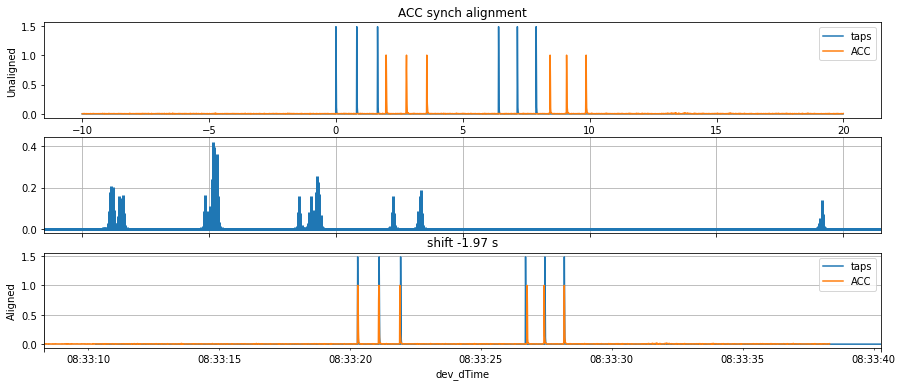

2023-02-16 08:33:20.294000+00:00


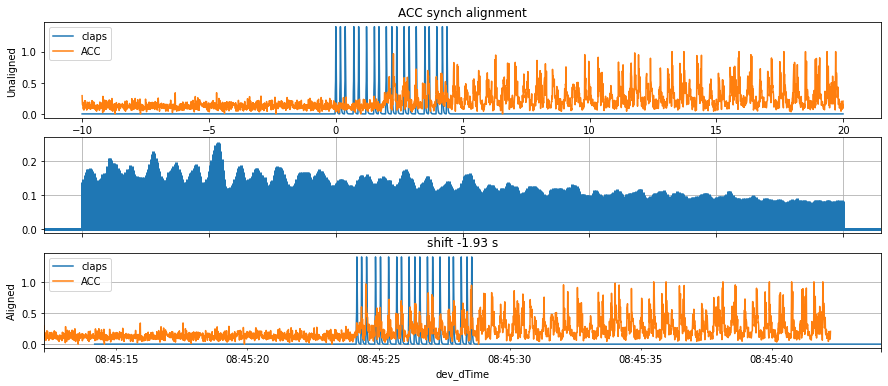

2023-02-16 08:45:24.176000+00:00


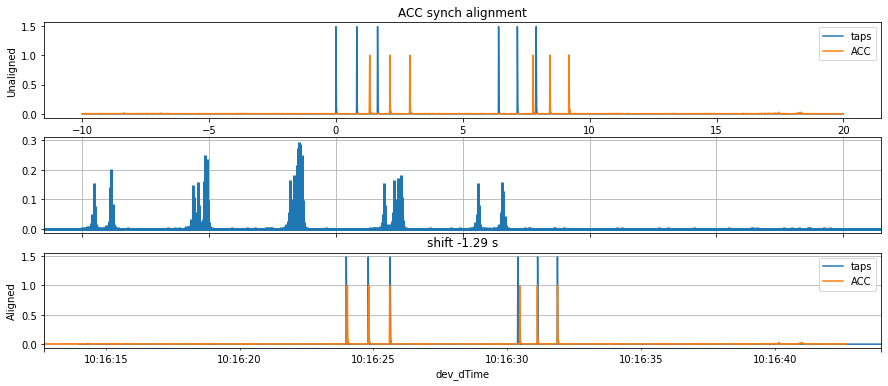

2023-02-16 10:16:23.987000+00:00


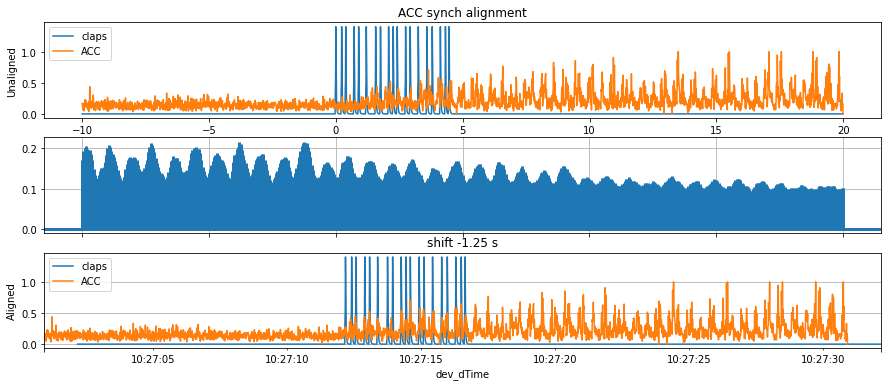

2023-02-16 10:27:12.177000+00:00


In [117]:
# ACC load
Results = {}
shifted_cues = {}
for c in synch_times.keys():
    cue = CueT[c].copy()
    prelim_synch_time = synch_times[c]
    t_range = [-10,20] # this is actually from the construction of cues
     # maybe could be t_range
    c_type = c_types[c] 

    Res = al.min_align(ACC,cue.loc[:,['sTime',c_type]],prelim_synch_time,3)
    Results[c] = Res
    shifted_cues[c] = Res['best']
    print(Res['best'])

If any of the automatic realignments needs correcting, inspect and test alternative alignments below

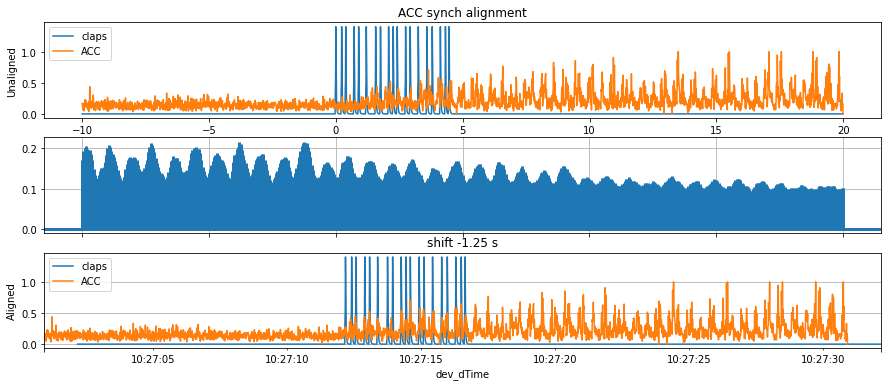

In [119]:
c = 'C2_Reic'
cue = CueT[c].copy()
prelim_synch_time = synch_times[c]
t_range = [-10,20] # this is actually from the construction of cues
 # maybe could be t_range
c_type = c_types[c] 
shift_limits = 3 # set the range of shifts (+/-) tests. It can be up to the length used to generate the results
Res = al.min_align(ACC,cue.loc[:,['sTime',c_type]],prelim_synch_time,3)

The middle plot is the cross correlation values. Set the ccthresh variable just below the peaks you want to check in alternative alignments

In [148]:
ccthresh = 0.2 # set threshold below 
peaks = al.alt_xc_peaks(Res,ccthresh)
peaks

,ind,corr,shift s
0,3,0.207270,-2.97
1,21,0.208250,-2.79
2,54,0.213464,-2.46
3,88,0.201460,-2.12
4,90,0.202855,-2.10
5,124,0.215910,-1.76
6,175,0.216469,-1.25


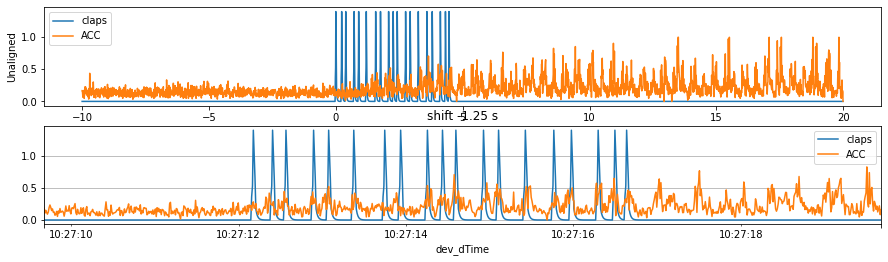

In [150]:
# specify the shift you want to check by peak or enter a shift offset in seconds in test_shift
pk_int = 6

shifted_cues[c] = al.test_shift(Res,peaks.loc[pk_int,'shift s'])

if that is correct, save those shifted values 

## Set up Cue detection through a whole set
With mechanism to correct entries

In [165]:
synch_times = {'C1_Synch':pd.to_datetime('2023-02-16 8:33:18.324+0000'),
               'C1_Reic':pd.to_datetime('2023-02-16 08:45:22.246+0000'),#'RE':pd.to_datetime('2023-02-15 11:25:26.573+0100'),
               'C2_Synch':pd.to_datetime('2023-02-16 10:16:22.697+0000'),
               'C2_Reic':pd.to_datetime('2023-02-16 10:27:10.927+0000')}
c_types = {'C1_Reic':'claps',#'RE':pd.to_datetime('2023-02-15 11:25:26.573+0100'),
                 'C2_Reic':'claps', # 97.0 
                 'C1_Synch':'taps',
                 'C2_Synch':'taps'}

In [168]:
eq_data_loc = '../Data/Equivital/Lydo_C1_C2/'
sep = '/'
projectName=''
df_datafiles = qex.qiosk_recordings(eq_data_loc,projectName,sep)
df_datafiles.set_index('DevName',inplace=True)

In [166]:
pi = 0
player_order = ['VN102','VN107','VN106','VN108','VN101','VN105','VN103','VN104','VN205','VN203','VN202','VN206','VN209','VN210','VN207','VN208','VN201','VN204','VA305','VA307','VA308','VA301','VA306','VA302','VA303','VA304','LS406','LS407','LS408','LS405','LS401','LS403','LS402','LS410','LS404','WW505','WW502','WW503','WW506','WW501','WW504','WW507','BR604','BR603','BR602','BR606','BR607','BR605','BR601','PC704','PC705','PC703','PC701','PC702','PC707']
pid = player_order[pi]

In [167]:
cues_aligned = pd.DataFrame(columns = synch_times.keys())

Cycle from here

In [1191]:
#pid= player_order[pi]
pid = 'BR602' # WW504    6107.171 vs 6107.9 ish

BR602


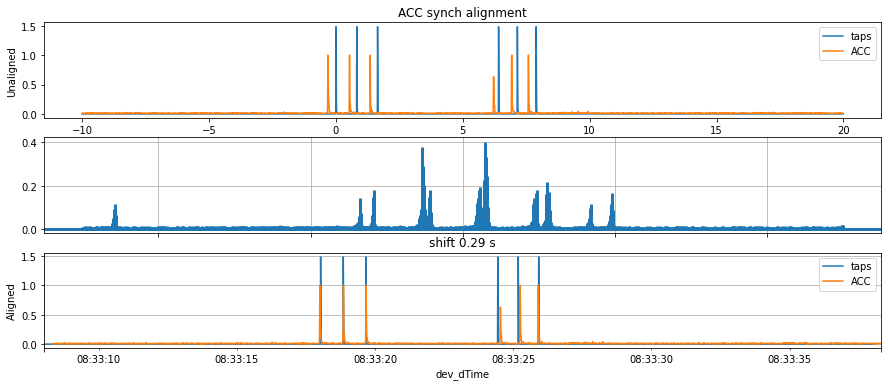

2023-02-16 08:33:18.034000+00:00


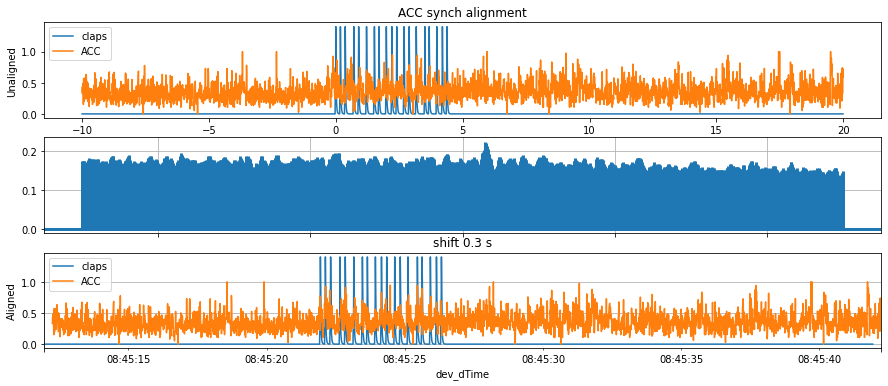

2023-02-16 08:45:21.946000+00:00


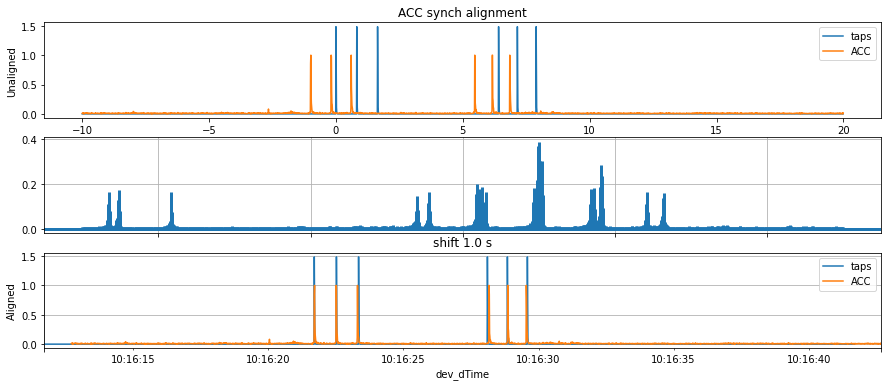

2023-02-16 10:16:21.697000+00:00


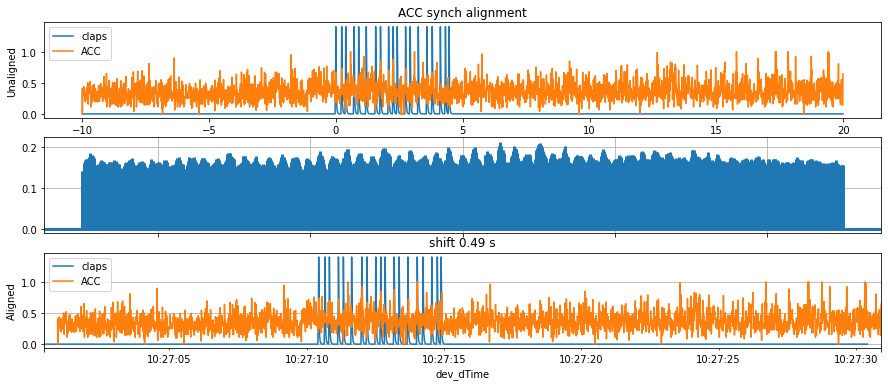

2023-02-16 10:27:10.437000+00:00


In [1198]:
print(pid)
sigFileLoc = '../Data/Equivital/Lydo_C1_C2/FASTACC'+ df_datafiles.loc[pid,'FileName'][4:]
V = pd.read_csv(sigFileLoc,skipinitialspace=True)
ACC = pd.DataFrame()
ACC['dev_dTime'] = pd.to_datetime(V['DateTime']) 
df = V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']]
ACC['signal'] = np.sqrt(np.square(df.diff()).sum(axis=1))
Results = {}

for c in synch_times.keys():
    cue = CueT[c].copy()
    prelim_synch_time = synch_times[c]
    c_type = c_types[c] 

    Res = al.min_align(ACC,cue.loc[:,['sTime',c_type]],prelim_synch_time,5)
    Results[c] = Res
    cues_aligned.loc[pid,c] = Res['best']
    print(Res['best'])

Check individual alignments

In [1104]:
c = 'C1_Synch'

In [1089]:
c = 'C1_Reic'

In [1124]:
c = 'C2_Synch'

In [1199]:
c = 'C2_Reic'

In [1090]:
cues_aligned.loc[pid,c] = np.datetime64('NaT')

C2_Reic


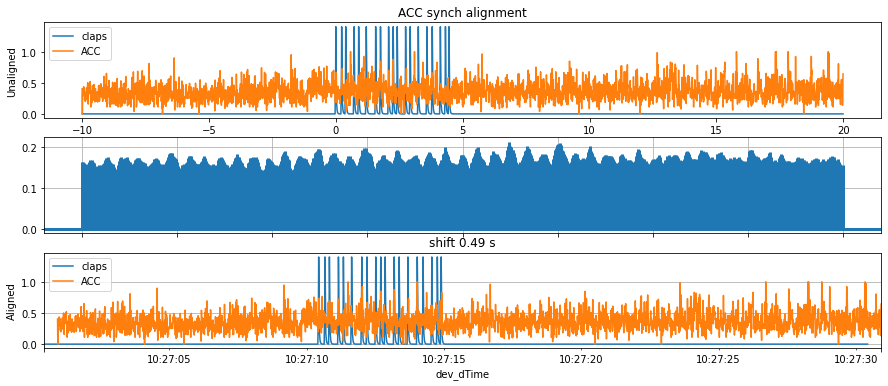

,ind,corr,shift s
0,416,0.200341,0.16
1,449,0.212981,0.49
2,468,0.201627,0.68
3,502,0.210375,1.02
4,534,0.203096,1.34


In [1200]:
print(c)
shift_limits = 3 # set the range of shifts (+/-) tests. It can be up to the length used to generate the results
Res = al.min_align(ACC,CueT[c].loc[:,['sTime',c_types[c]]],synch_times[c],4)

ccthresh = 0.2 # set threshold below 
peaks = al.alt_xc_peaks(Res,ccthresh)
peaks

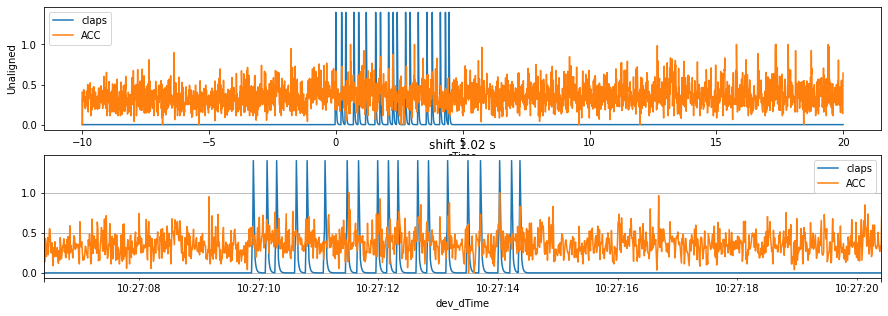

2023-02-16 10:27:09.907000+00:00


In [1201]:
# specify the shift you want to check by peak or enter a shift offset in seconds in test_shift
pk_int =3
cues_aligned.loc[pid,c] = al.test_shift(Res,peaks.loc[pk_int,'shift s'])
print(cues_aligned.loc[pid,c])

In [ ]:
-2.42

In [1202]:
cues_aligned.to_csv('C1_C2_Equivitals.csv')
cues_aligned
# add a row for ctime vales, 0 for synch and Reic start offset for Reich within each concert

,C1_Synch,C1_Reic,C2_Synch,C2_Reic
VN102,2023-02-16 08:33:18.264000+00:00,2023-02-16 08:45:22.016000+00:00,2023-02-16 10:16:21.637000+00:00,2023-02-16 10:27:09.787000+00:00
VN107,NaT,2023-02-16 08:45:23.396000+00:00,NaT,2023-02-16 10:27:11.347000+00:00
VN106,2023-02-16 08:33:19.384000+00:00,2023-02-16 08:45:23.256000+00:00,2023-02-16 10:16:23.097000+00:00,2023-02-16 10:27:11.257000+00:00
VN108,2023-02-16 08:33:19.864000+00:00,2023-02-16 08:45:23.586000+00:00,2023-02-16 10:16:23.417000+00:00,2023-02-16 10:27:11.567000+00:00
VN101,NaT,2023-02-16 08:45:23.086000+00:00,2023-02-16 10:16:22.717000+00:00,2023-02-16 10:27:10.727000+00:00
VN105,2023-02-16 08:33:19.014000+00:00,2023-02-16 08:45:22.896000+00:00,2023-02-16 10:16:22.437000+00:00,2023-02-16 10:27:10.607000+00:00
VN104,2023-02-16 08:33:19.874000+00:00,2023-02-16 08:45:23.726000+00:00,2023-02-16 10:16:23.207000+00:00,2023-02-16 10:27:11.417000+00:00
VN103,2023-02-16 08:33:19.414000+00:00,2023-02-16 08:45:23.266000+00:00,2023-02-16 10:16:22.777000+00:00,2023-02-16 10:27:10.987000+00:00
VN205,2023-02-16 08:33:20.374000+00:00,2023-02-16 08:45:24.166000+00:00,2023-02-16 10:16:23.947000+00:00,2023-02-16 10:27:12.127000+00:00
VN203,2023-02-16 08:33:19.174000+00:00,2023-02-16 08:45:22.956000+00:00,2023-02-16 10:16:22.837000+00:00,2023-02-16 10:27:10.997000+00:00


In [1033]:
pi+=1

In [1034]:
pid

'VN202'

# device time variance

In [1138]:
print((cues_aligned['C1_Reic'] - cues_aligned['C1_Synch']).dt.total_seconds().mean())
print((cues_aligned['C1_Reic'] - cues_aligned['C1_Synch']).dt.total_seconds().std())

723.8473488372092
0.056076004426364214


In [1139]:
print((cues_aligned['C2_Reic'] - cues_aligned['C2_Synch']).dt.total_seconds().mean())
print((cues_aligned['C2_Reic'] - cues_aligned['C2_Synch']).dt.total_seconds().std())

648.185576923077
0.05647881648827222


In [1140]:
print((cues_aligned['C2_Reic'] - cues_aligned['C1_Reic']).dt.total_seconds().mean())
print((cues_aligned['C2_Reic'] - cues_aligned['C1_Reic']).dt.total_seconds().std())

6107.962568627452
0.11550536868934343


In [1141]:
print((cues_aligned['C2_Synch'] - cues_aligned['C1_Synch']).dt.total_seconds().mean())
print((cues_aligned['C2_Synch'] - cues_aligned['C1_Synch']).dt.total_seconds().std())

6183.627545454546
0.10035876447405005


While there is substantial noise in alignments over the 10 minute ish interval between initial synch and Reich for these two concerts, this noise does not increase linearly. the variation in clocks accumulated in 100 minutes is only twice the 10 minute noise, suggesting a substantial part of that is measurement error (cue execution and detection variance) instead of linear noise increasing at a rate of 5 ms per minute. 

Would this noise be the same if alignment were assessed at a higher sample rate?

In [1136]:
(cues_aligned['C2_Synch'] - cues_aligned['C1_Synch']).dt.total_seconds()

VN102    6183.373
VN107         NaN
VN106    6183.713
VN108    6183.553
VN101         NaN
VN105    6183.423
VN104    6183.333
VN103    6183.363
VN205    6183.573
VN203    6183.663
VN202         NaN
VN206    6183.633
VN209         NaN
VN210         NaN
VN207    6183.603
VN208    6183.693
VN201    6183.593
VN204    6183.623
VA305    6183.683
VA307    6183.683
VA308    6183.743
VA301    6183.683
VA306         NaN
VA302    6183.613
VA303    6183.663
VA304    6183.693
LS406    6183.693
LS407    6183.703
LS408    6183.693
LS405    6183.633
LS401    6183.753
LS403    6183.613
LS402    6183.743
LS410    6183.653
LS404         NaN
WW505    6183.563
WW502    6183.523
WW503         NaN
WW506    6183.663
WW501    6183.723
WW504    6183.603
WW507    6183.643
BR604    6183.713
BR603         NaN
BR606    6183.573
BR607    6183.633
BR605    6183.603
BR601    6183.703
PC704    6183.733
PC705    6183.643
PC703    6183.683
PC701         NaN
PC702    6183.703
PC707    6183.523
dtype: float64

In [1037]:
(cues_aligned['C2_Reic'] - cues_aligned['C2_Synch']).dt.total_seconds()

VN102    648.15
VN107       NaN
VN106    648.16
VN108    648.15
VN101    648.01
VN105    648.17
VN104    648.21
VN103    648.21
VN205    648.18
VN203    648.16
VN202    648.29
VN206    648.12
VN209    648.19
VN210    648.20
VN207    648.22
VN208    648.23
VN201    648.26
VN204    648.19
VA305    648.10
VA307    648.21
VA308    648.13
VA301    648.12
VA306    648.34
VA302    648.23
VA303    648.22
VA304    648.19
LS406    648.20
LS407    648.20
LS408    648.17
LS405    648.24
LS401    648.15
LS403    648.22
LS402    648.20
LS410    648.16
LS404    648.13
WW505    648.13
WW502    648.29
WW503    648.22
WW506    648.13
WW501    648.07
WW504    648.23
WW507    648.24
BR604    648.12
BR603    648.13
BR606    648.22
BR607    648.19
BR605    648.22
BR601    648.15
PC704    648.23
PC705    648.18
PC703    648.21
PC701    648.21
PC702    648.22
PC707    648.18
dtype: float64

In [1038]:
(cues_aligned['C2_Reic'] - cues_aligned['C1_Reic']).dt.total_seconds()

VN102    6107.771
VN107    6107.951
VN106    6108.001
VN108    6107.981
VN101    6107.641
VN105    6107.711
VN104    6107.691
VN103    6107.721
VN205    6107.961
VN203    6108.041
VN202    6108.371
VN206    6107.911
VN209         NaN
VN210    6107.991
VN207    6108.001
VN208    6107.971
VN201    6108.061
VN204    6107.981
VA305    6107.951
VA307    6108.001
VA308    6108.001
VA301    6107.941
VA306    6107.691
VA302    6107.951
VA303    6108.021
VA304    6108.001
LS406    6108.001
LS407    6108.041
LS408    6108.021
LS405    6107.971
LS401    6107.991
LS403    6107.941
LS402    6108.011
LS410    6107.961
LS404    6107.921
WW505    6107.991
WW502    6107.971
WW503         NaN
WW506    6107.951
WW501    6107.961
WW504    6107.171
WW507    6108.001
BR604    6107.981
BR603    6108.041
BR606    6107.951
BR607    6107.971
BR605    6107.961
BR601    6108.021
PC704    6108.091
PC705    6107.971
PC703    6107.991
PC701    6107.981
PC702    6108.051
PC707    6108.031
dtype: float64

# check alignment quality



In [1237]:
Piece_timings = pd.read_csv('/Users/finn/Desktop/Current_Projects/Stavanger/Analysis/Timing/ctimes.csv',index_col = 'Event')
c_times = {'RD':pd.to_datetime('2023-02-15 12:05:36.897+0100'), # 97.0 
                 'C1':pd.to_datetime('2023-02-16 9:33:18.324+0100'),
                 'C2':pd.to_datetime('2023-02-16 11:16:22.697+0100'),
                 'C3':pd.to_datetime('2023-02-17 9:30:51.841+0100'),
                 'C4':pd.to_datetime('2023-02-17 11:16:29.298+0100'),
                 'C5':pd.to_datetime('2023-02-18 16:10:29.583+0100')}
# translate Piece_timings to Piece_dt
Piece_dt = pd.DataFrame(index = Piece_timings.index, columns = Piece_timings.columns)
for col in Piece_timings.columns:
    Piece_dt[col] = pd.to_timedelta(Piece_timings[col],unit='s')+c_times[col]
Piece_dt.index

Index(['Pre-Audio', 'Warmup', 'Tuning', 'Synch Taps', 'Applause for Conductor',
       'Saevarud', 'Applause for Saevarud', 'MC pre Reich', 'Reich',
       'Applause for Reich', 'MC pre Arban', 'Applause for Florian', 'Arban',
       'Applause for Arban', 'MC pre Grieg', 'Grieg', 'Applause for Grieg',
       'MC pre Tsjajkovskij', 'Tsjajkovskij', 'Applause for Tsjajkovskij',
       'MC pre Christophersen', 'Christophersen',
       'Applause for Christophersen', 'MC pre School',
       'Applause for school class', 'MC pre Vivaldi', 'Vivaldi',
       'Applause for Vivaldi', 'MC post Vivaldi', 'Applause for school class',
       'MC pre Strauss', 'Strauss', 'Applause for Strauss', 'End'],
      dtype='object', name='Event')

In [1238]:
files_list = pd.Series(index = player_order,dtype='object')
for pid in player_order:
    files_list[pid] = '../Data/Equivital/Lydo_C1_C2/RESPACC'+ df_datafiles.loc[pid,'FileName'][4:]

In [1169]:
files_list = pd.Series(index = player_order,dtype='object')
for pid in player_order:
    files_list[pid] = '../Data/Equivital/Lydo_C1_C2/FASTACC'+ df_datafiles.loc[pid,'FileName'][4:]

In [1239]:
c = 'C2_Reic'
Pieces = Piece_timings.loc[:,'C2'] #- Piece_timings.loc['Reich','C2'] 
cue_times = cues_aligned.loc[:,c].copy()
sep = '/'
path = '../Data/Equivital/Lydo_C1_C2/'

s_dtime=(Piece_dt.loc['Tuning','C2']).tz_convert(tz=dt.timezone.utc)
e_dtime=(Piece_dt.loc['End','C2']).tz_convert(tz=dt.timezone.utc)
s_time=Pieces.loc['Tuning']
e_time=Pieces.loc['End']
[s_dtime,e_dtime]
[s_time,e_time]

[-49.122, 3535.87]

In [1240]:
# signal File type and column name (multi sample)
sf = 25 # seconds 
dur = e_time - s_time
time_s = s_time +  np.round(np.linspace(0,dur,int(sf*(dur)),endpoint=False),3)
time_dt = s_dtime + pd.to_timedelta(time_s,unit='s')

df_sig = pd.DataFrame(index = time_dt,columns=player_order)

In [1246]:
for pid in player_order:
    if not pd.isnull(cue_times[pid]):
        dataFile = files_list[pid]
        V = pd.read_csv(dataFile,skipinitialspace=True)
        RESP = pd.DataFrame()
        RESP['dev_dTime'] = pd.to_datetime(V['DateTime']) 
        RESP['concert_time'] = (ACC['dev_dTime'].dt.tz_localize(None) - cue_times[pid].tz_localize(None)).dt.total_seconds() + Piece_timings.loc['Reich','C2'] 
        df = V.loc[:,['Breathing']]
        RESP['signal'] = df.diff() # taking respiration diff 

        f = interpolate.interp1d(RESP['concert_time'],RESP['signal'],fill_value='extrapolate')
        new_sig = f(time_s)
        
        df_sig.loc[:,pid] = new_sig

    else: # if the signal can't be synched, skip it.
        df_sig.loc[:,pid] = np.nan

In [1242]:
for pid in player_order:
    if not pd.isnull(cue_times[pid]):
        dataFile = files_list[pid]
        V = pd.read_csv(dataFile,skipinitialspace=True)
        ACC = pd.DataFrame()
        ACC['dev_dTime'] = pd.to_datetime(V['DateTime']) 
        ACC['concert_time'] = (ACC['dev_dTime'].dt.tz_localize(None) - cue_times[pid].tz_localize(None)).dt.total_seconds() + Piece_timings.loc['Reich','C2'] 
        df = V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']]
        ACC['signal'] = np.sqrt(np.square(df.diff()).sum(axis=1))

        f = interpolate.interp1d(ACC['concert_time'],ACC['signal'],fill_value='extrapolate')
        new_sig = f(time_s)
        
        df_sig.loc[:,pid] = new_sig

    else: # if the signal can't be synched, skip it.
        df_sig.loc[:,pid] = np.nan

KeyError: "None of [Index(['Vert Accelerometer', 'Lat Accelerometer', 'Long Accelerometer'], dtype='object')] are in the [columns]"

In [1254]:
acc_df = pd.DataFrame(index = time_s,columns = df_sig.columns, data = df_sig.values)

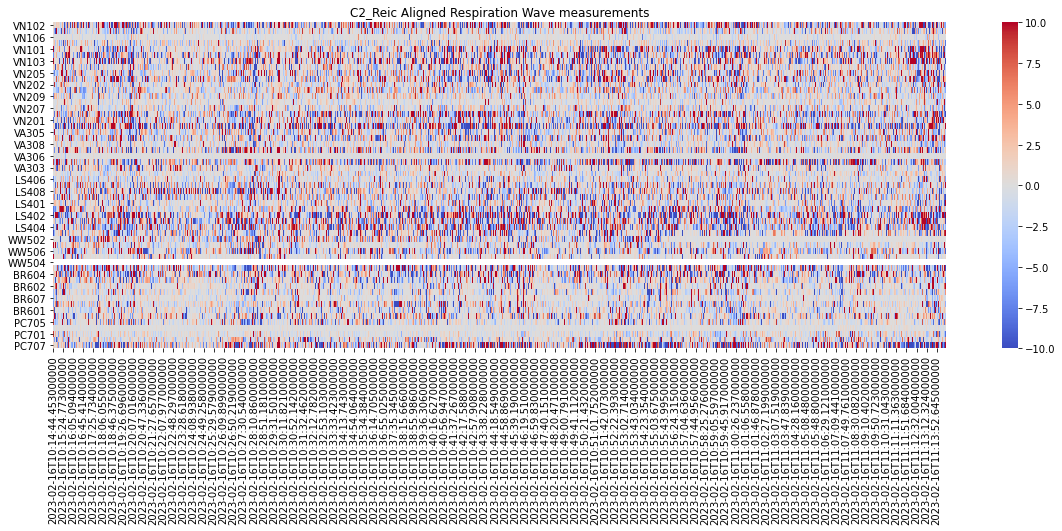

In [1253]:
fig, (ax1) = plt.subplots(1, 1,figsize = [20,6])
chart = sns.heatmap(data=df_sig.transpose(), ax=ax1,vmin=-10, vmax=10, cbar=True,cmap="coolwarm") # ,alpha=0.8
plt.title(c + ' Aligned Respiration Wave measurements')
#plt.savefig('./plots/'+projectName+'_'+ interval_name+ '_set_'+sigName+'.png',dpi = 300)
plt.show()

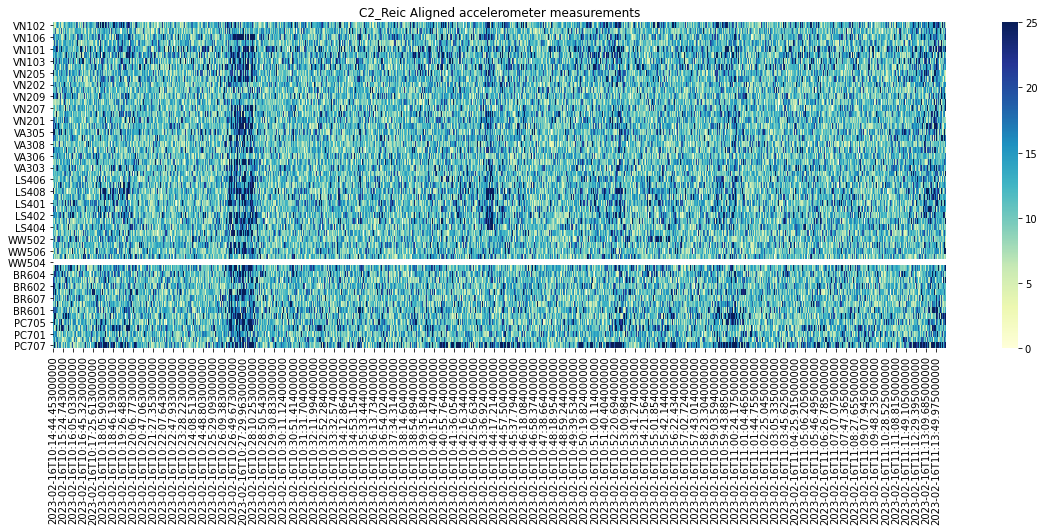

In [1232]:
fig, (ax1) = plt.subplots(1, 1,figsize = [20,6])
chart = sns.heatmap(data=df_sig.transpose(), ax=ax1,vmin=0, vmax=25, cbar=True,cmap="YlGnBu") # ,alpha=0.8
plt.title(c + ' Aligned accelerometer measurements')
#plt.savefig('./plots/'+projectName+'_'+ interval_name+ '_set_'+sigName+'.png',dpi = 300)
plt.show()

In [1263]:
t1=(Piece_dt.loc['Strauss','C2']).tz_convert(tz=dt.timezone.utc) # 'Strauss', 'Applause for Strauss'
t2=(Piece_dt.loc['Applause for Strauss','C2']).tz_convert(tz=dt.timezone.utc)
interval_name = 'Stra'
sub_sig = df_sig.loc[t1:t2,:].copy()

In [1258]:
t1=Piece_timings.loc['Christophersen','C2'] - 5# 'Strauss', 'Applause for Strauss'
t2=Piece_timings.loc['Applause for Reich','C2']+10
interval_name = 'Reich'
sub_sig = acc_df.loc[t1:t2,:].copy()

In [1266]:
t1=Piece_timings.loc['Christophersen','C2'] - 5# 'Strauss', 'Applause for Strauss' 'Christophersen',
t2=Piece_timings.loc['Applause for Christophersen','C2']+10
interval_name = 'C2_Chri'
sub_sig = acc_df.loc[t1:t2,:].copy()

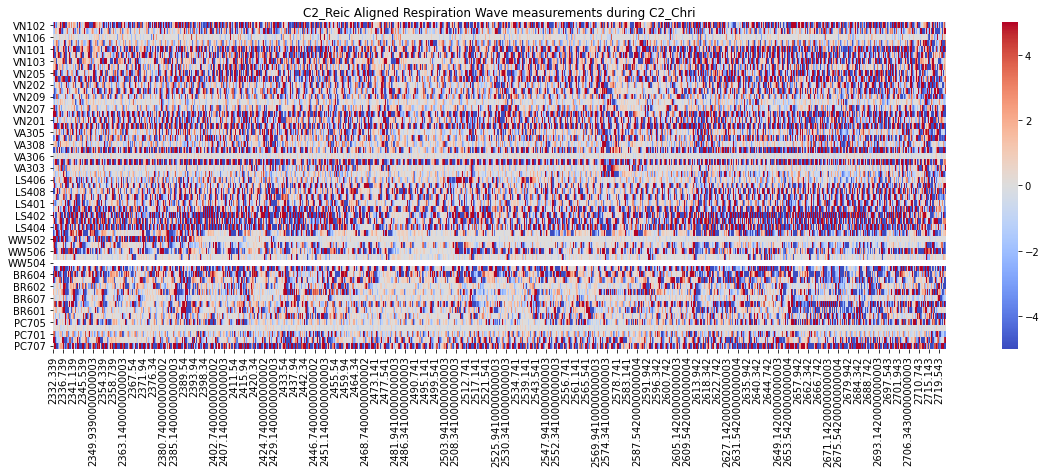

In [1267]:
fig, (ax1) = plt.subplots(1, 1,figsize = [20,6])
chart = sns.heatmap(data=sub_sig.transpose(), ax=ax1,vmin=-5, vmax=5, cbar=True,cmap="coolwarm") # ,alpha=0.8
plt.title(c + ' Aligned Respiration Wave measurements during '+ interval_name)
plt.savefig('./plots/'+c+'_aligned_'+ interval_name+ '_set_RESP.png',dpi = 300)
plt.show()

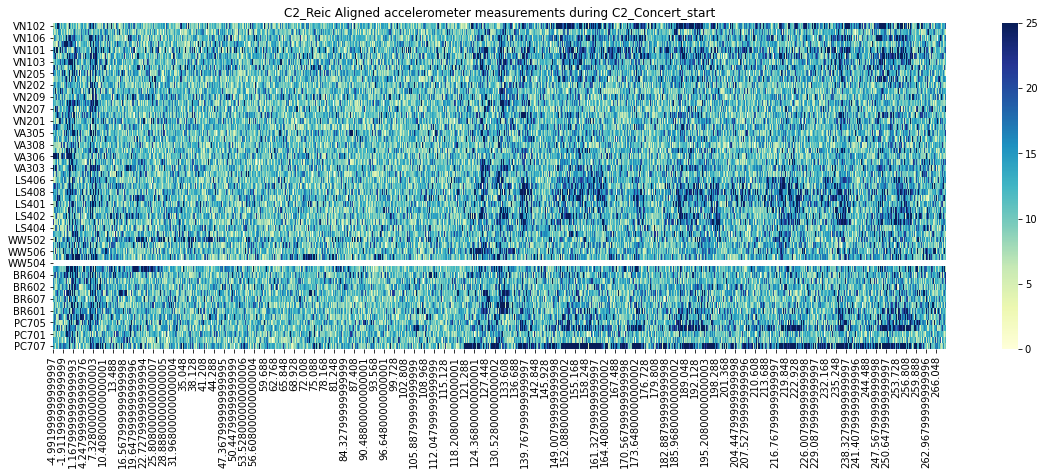

In [1236]:
fig, (ax1) = plt.subplots(1, 1,figsize = [20,6])
chart = sns.heatmap(data=sub_sig.transpose(), ax=ax1,vmin=0, vmax=25, cbar=True,cmap="YlGnBu") # ,alpha=0.8
plt.title(c + ' Aligned accelerometer measurements during '+ interval_name)
plt.savefig('./plots/'+c+'_aligned_'+ interval_name+ '_set_ACC.png',dpi = 300)
plt.show()

# to do

1. Compensate for sync times at synch cues missing for a full list of alignments. Compromis with Reic times if necessary.
2. Get cue timings for Movesense and AX3
3. Convert to concert time and cut all aligned signals per participant, Full concert and piece-wise, preserving device time but adding concert time and piece time in seconds